In [1]:
import tensorflow as tf
from tensorflow import keras

import SimpleITK as sitk
import numpy as np
import pandas as pd
import json

from scipy import ndimage
import matplotlib.pyplot as plt

from sklearn.model_selection  import train_test_split

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
import math

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def read_nifti_file(file_path, interpolator = sitk.sitkLinear, new_spacing=[1, 1, 1]):
    """Read and load volume"""
    # Read file
    img = sitk.ReadImage(file_path)
    # 轉為 NumPy 陣列
    img_arr = sitk.GetArrayFromImage(img)

    # ori_spacing = img.GetSpacing()
    # ori_size = img.GetSize()
    # new_size = [int(round(osz*ospc/nspc)) for osz, ospc nspc in zip(ori_size, ori_spacing, new_spacing)]

    return img_arr

def resample_image(file_path, out_spacing=[1.0, 1.0, 1.0], is_label=False):
    # Read file
    itk_image = sitk.ReadImage(file_path)
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    # out_size = [
    #     int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
    #     int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
    #     int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))
    # ]
    # 上述也可以直接用下面这句简写
    out_size = [int(round(osz*ospc/nspc)) for osz,ospc,nspc in zip(original_size, original_spacing, out_spacing)]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label: # 如果是mask图像，就选择sitkNearestNeighbor这种插值
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
        resample.SetDefaultPixelValue(0)
    else: # 如果是普通图像，就采用sitkBSpline插值法
        resample.SetInterpolator(sitk.sitkBSpline)

    img = resample.Execute(itk_image)
    img = sitk.GetArrayFromImage(img)
    # deal with rare case
    img[:, :, -1] = 0

    return img
    # return resample.Execute(itk_image)

In [25]:
resample_rs = resample_image(mask_path[8], out_spacing=[1.0, 1.0, 1.0], is_label=False)
sitk.WriteImage(resample_rs,"mask_8.nii.gz")

In [4]:
def dis(a_pos, b_pos):
    return math.sqrt(pow(a_pos[0] - b_pos[0], 2) + 
                     pow(a_pos[1] - b_pos[1], 2) + 
                     pow(a_pos[2] - b_pos[2], 2) * 1.0)

def find_regions(region):
    # There might be multiple tumors
    tumors = []
    tumors.append([(region[0][0], region[1][0], region[2][0])])
    tumor_idx = 1

    for i in range(1, len(region[0])):
        # (x, y, z) if x axis more than 10. -> thought to be another tumors
        x_dis = abs(region[0][i] - tumors[tumor_idx - 1][-1][0])
        y_dis = abs(region[1][i] - tumors[tumor_idx - 1][-1][1])
        z_dis = abs(region[2][i] - tumors[tumor_idx - 1][-1][2])
        
        if x_dis >= 10:
            tumors.append([(region[0][i], region[1][i], region[2][i])])
            tumor_idx += 1
        else:
            tumors[tumor_idx - 1].append((region[0][i], region[1][i], region[2][i]))
    return tumors

def get_bounding_box(mask, loc):
    tumor_x = [ _point[0] for _point in loc ]
    tumor_y = [ _point[1] for _point in loc ]
    tumor_z = [ _point[2] for _point in loc ]

    l_width = max(min(tumor_x) - 5, 0)
    l_height = max(min(tumor_y) - 5, 0)
    l_depth = max(min(tumor_z) - 5, 0)

    r_width = min(max(tumor_x) + 5, mask.shape[0])
    r_height = min(max(tumor_y) + 5, mask.shape[1])
    r_depth = min(max(tumor_z) + 5, mask.shape[2])

    return (l_width, l_height, l_depth), (r_width, r_height, r_depth)

def check_edge(kid_l, kid_r, tumor_l, tumor_r):
    l_width = min(kid_l[0], tumor_l[0])
    l_height = min(kid_l[1], tumor_l[1])
    l_depth = min(kid_l[2], tumor_l[2])

    r_width = max(kid_r[0], tumor_r[0])
    r_height = max(kid_r[1], tumor_r[1])
    r_depth = max(kid_r[2], tumor_r[2])

    return (l_width, l_height, l_depth), (r_width, r_height, r_depth)


def get_bounding_box_with_kidney(mask):
    kidney_region = np.where(mask == 1)
    kidneys = find_regions(kidney_region)

    max_tumor, tumor_l, tumor_r = get_max_tumor(mask)
    if len(kidneys) == 1:
        print('----- Strange: only 1 kidney ------')
        kid_l, kid_r = get_bounding_box(mask, kidneys[0])
        l_box, r_box = check_edge(kid_l, kid_r, tumor_l, tumor_r)
        return max_tumor, kidneys[0], l_box, r_box

    min_dis = 66666
    nearest_kid = kidneys[0]

    for _kidney in kidneys:
        kid_l, kid_r = get_bounding_box(mask, _kidney)
        kid_dis = dis(kid_l, tumor_l) + dis(kid_r, tumor_r)

        if kid_dis < min_dis:
            min_dis = kid_dis
            nearest_kid = _kidney

    kid_l, kid_r = get_bounding_box(mask, nearest_kid)
    l_box, r_box = check_edge(kid_l, kid_r, tumor_l, tumor_r)

    return max_tumor, nearest_kid, l_box, r_box

    # a_kid_l, a_kid_r = get_bounding_box(mask, kidneys[0])
    # b_kid_l, b_kid_r = get_bounding_box(mask, kidneys[1])

    # # print('tumor box:', tumor_l, ',', tumor_r)
    # # print('A kidney box:', a_kid_l, ',', a_kid_r)
    # # print('B kidney box:', b_kid_l, ',', b_kid_r)

    # a_kid_dis = dis(a_kid_l, tumor_l) + dis(a_kid_r, tumor_r)
    # b_kid_dis = dis(b_kid_l, tumor_l) + dis(b_kid_r, tumor_r)

    # if a_kid_dis < b_kid_dis:
    #     # top left and right bottom must check with tumor boudning box
    #     l_box, r_box = check_edge(a_kid_l, a_kid_r, tumor_l, tumor_r)
    #     return max_tumor, kidneys[0], l_box, r_box
    # else:
    #     l_box, r_box = check_edge(b_kid_l, b_kid_r, tumor_l, tumor_r)
    #     return max_tumor, kidneys[1], l_box, r_box

def get_max_tumor(mask):
    tumor_region = np.where(mask == 2)

    # There is no tumors in the img
    if len(tumor_region[0]) == 0:
        return (666, 666, 666), (0, 0, 0)

    tumors = find_regions(tumor_region)
    # sorted the tumors and get the biggest part
    sorted(tumors, key=lambda x: len(x))
    max_tumor = tumors[-1]

    l_box, r_box= get_bounding_box(mask, max_tumor)
    return max_tumor, l_box, r_box


def crop_tumor(img, mask, tumor_only=False, with_kidney=False):
    if with_kidney is True:
        max_tumor, kidney, l_box, r_box = get_bounding_box_with_kidney(mask)    
    else:
        max_tumor, l_box, r_box = get_max_tumor(mask)

    # turn the kidney part to black
    img = img[l_box[0]: r_box[0], l_box[1]: r_box[1], l_box[2]: r_box[2]]

    if tumor_only is True:
        box = np.full((r_box[0] - l_box[0], r_box[1] - l_box[1], r_box[2] - l_box[2]), -1024)
        # print(box.shape, ',', img.shape)
        for _tumor in max_tumor:
            x = _tumor[0] - l_box[0]
            y = _tumor[1] - l_box[1]
            z = _tumor[2] - l_box[2]
            box[x][y][z] = img[x][y][z]

        # for _kid in kidney:
        #     x = _kid[0] - l_box[0]
        #     y = _kid[1] - l_box[1]
        #     z = _kid[2] - l_box[2]
        #     box[x][y][z] = img[x][y][z]
        return box

    # (l_width, l_height, l_depth), (r_width, r_height, r_depth)
    return img


In [110]:
mask = read_nifti_file(mask_path[8])

kidney_region = np.where(mask == 1)
kidneys = find_regions(kidney_region)

In [144]:
max_tumor, kid, l_b, r_b = get_bounding_box_with_kidney(mask)

print(l_b, r_b)

(259, 187, 349) (348, 279, 477)


In [143]:
kidney_region = np.where(mask == 1)
kidney_region

(array([ 91,  91,  91, ..., 342, 343, 343], dtype=int64),
 array([239, 239, 240, ..., 224, 219, 220], dtype=int64),
 array([388, 389, 385, ..., 432, 432, 432], dtype=int64))

In [142]:
mask[:, :, -1] = 0

In [124]:
mask = read_nifti_file(mask_path[8])
mask

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [100]:
for _kid in kidneys:
    print(_kid[0], ', ', _kid[-1])
    print('-'*20)

(111, 298, 130) ,  (123, 278, 125)
--------------------
(134, 239, 148) ,  (237, 198, 162)
--------------------
(325, 299, 127) ,  (421, 270, 144)
--------------------


In [5]:
#  input mask
# data_dir = 'C:\\Users\\Gina\\Lab\\kidney\\nnUNet-1\\Result'
data_dir = 'C:\\Users\\Gina\\Lab\\kidney\\nnUNet-1\\DataSet\\nnUnet_raw\\nnUNet_raw_data\\Task135_KiTS2021\\imagesTr'
mask_dir = 'C:\\Users\\Gina\\Lab\\kidney\\nnUNet-1\\Result'

data_path = []
mask_path = []

# append the mask files
for file in os.listdir(mask_dir):
    if "nii.gz" in file:
        mask_path.append(os.path.join(mask_dir, file))

# append the original image files
for file in os.listdir(data_dir):
    if "nii.gz" in file:
        data_path.append(os.path.join(data_dir, file))

In [11]:
img = read_nifti_file(data_path[4])
mask = read_nifti_file(mask_path[4])
test = crop_tumor(img, mask, True, True)

(81, 98, 223) , (81, 98, 223)


In [8]:
def plot_3d(image, threshold=0, to_show=False, title='img'):
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    if to_show is True:
        plt.savefig('resample_kidney_box_tumor//img//'+ title + '.png')
        plt.close()
    else:
        plt.show()


In [13]:
plot_3d(test, 0, True, 'img')

In [140]:
img = resample_image(data_path[8], out_spacing=[1.0, 1.0, 1.0], is_label=False)
print(img.shape)
mask = resample_image(mask_path[8], out_spacing=[1.0, 1.0, 1.0], is_label=False)
print(mask.shape)
# img = crop_tumor(img, mask, True, True)

(418, 418, 681)
(418, 418, 681)


In [7]:
def resize_volume(img, desired_depth=64, desired_width=128, desired_height=128):
    """Resize across z-axis"""
    
    # Get current depth
    current_width = img.shape[0]
    current_height = img.shape[1]
    current_depth = img.shape[-1]
    
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height

    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [19]:
img_path

'C:\\Users\\Gina\\Lab\\kidney\\nnUNet-1\\DataSet\\nnUnet_raw\\nnUNet_raw_data\\Task135_KiTS2021\\imagesTr\\case_00010_0000.nii.gz'

In [9]:
idx = 0
for img_path, mask in zip(data_path, mask_path):
    try:
        # img = read_nifti_file(img_path)
        # mask = read_nifti_file(mask)
        img = resample_image(img_path, out_spacing=[1.0, 1.0, 1.0], is_label=False)
        # sitk.WriteImage(img, f"resize//img_{idx}.nii.gz")

        mask = resample_image(mask, out_spacing=[1.0, 1.0, 1.0], is_label=True)
        # sitk.WriteImage(mask, f"resize//mask_{idx}.nii.gz")

        # size_info.append(img.shape)    
        img = crop_tumor(img, mask, True, True)

        plot_3d(img, 0, True, str(idx))
        np.save(f"resample_kidney_box_tumor//case_{idx}.npy", img)

        del img
        del mask
    except:
        print(img_path)
    idx += 1

----- Strange: only 1 kidney ------
----- Strange: only 1 kidney ------
C:\Users\Gina\Lab\kidney\nnUNet-1\DataSet\nnUnet_raw\nnUNet_raw_data\Task135_KiTS2021\imagesTr\case_00064_0000.nii.gz
C:\Users\Gina\Lab\kidney\nnUNet-1\DataSet\nnUnet_raw\nnUNet_raw_data\Task135_KiTS2021\imagesTr\case_00103_0000.nii.gz
----- Strange: only 1 kidney ------
----- Strange: only 1 kidney ------
----- Strange: only 1 kidney ------
----- Strange: only 1 kidney ------
C:\Users\Gina\Lab\kidney\nnUNet-1\DataSet\nnUnet_raw\nnUNet_raw_data\Task135_KiTS2021\imagesTr\case_00234_0000.nii.gz
----- Strange: only 1 kidney ------
----- Strange: only 1 kidney ------


In [11]:
ct_data = []
data_info = []
for idx in range(300):
    if idx in [64, 103, 234]:
        continue
    _tumor = np.load(f"resample_kidney_box_tumor/case_{idx}.npy")
    # _tumor[_tumor == -1024] = 0
    ct_data.append(_tumor)
    
    row = {}
    row['image_idx'] = idx
    row['x'] = _tumor.shape[0]
    row['y'] = _tumor.shape[1]
    row['z'] = _tumor.shape[2]
    row['volume'] = len(np.where(_tumor != -1024)[0])
    data_info.append(row)

data_info = pd.DataFrame(data_info)

data_info.head(5)

,image_idx,x,y,z,volume
0,0,75,91,116,7603
1,1,83,103,118,5105
2,2,96,96,117,37282
3,3,85,97,103,10784
4,4,100,74,129,22672


In [12]:
data_info.to_csv('output/resample_kidney.csv')

In [65]:
ct_data = np.array(list(map(resize_volume, ct_data)))

In [116]:
with open('C:\\Users\\Gina\\Lab\\kidney\\kits21\\kits21\\data\\kits.json') as f:
    label = json.load(f)
    label = pd.DataFrame(label)

# drop useless img index
drop_img = [64, 103, 234]
label = label.drop(drop_img)
label.index = range(len(label))

In [67]:
filter_a = label['pathologic_size'] <= 4.0
filter_b = label['malignant'] == False
filter_c = label['pathology_t_stage'] == '1a'
filter_d = label['pathology_t_stage'] == '1b'
filter_e = label['pathology_t_stage'] == '3'

label[(filter_a & (filter_c | filter_d | filter_e))].shape

(130, 38)

In [121]:
label[filter_a]['case_id'].to_csv('tumor_4mm.csv')

In [61]:
tmpb = label_benign['malignant'] == False

label_benign[(tmpb)].shape

(14, 3)

In [68]:
# extrace col
label_grade = label[(filter_a & (filter_c | filter_d | filter_e))]
drop_index = label[~(filter_a & (filter_c | filter_d | filter_e))].index

label_grade = label_grade[['tumor_isup_grade', 'pathology_t_stage', 'malignant']]
label_grade = label_grade.rename(columns={'tumor_isup_grade': 'grade', 'pathology_t_stage': 'stage'})

ct_grade = np.delete(ct_data, drop_index, axis=0) 

label_grade.loc[ label_grade['grade'] <= 2, ['grade'] ] = 0
label_grade.loc[ label_grade['grade'] > 2, ['grade'] ] = 1

# reindex -> due to ct data
label_grade.index = range(len(label_grade))
drop_index = label_grade[label_grade['grade'].isna()].index.tolist()

# drop for missing grade
label_grade = label_grade.drop(index=drop_index)
label_grade.index = range(len(label_grade))
ct_grade = np.delete(ct_grade, drop_index, axis=0)

print('ct shape:', ct_grade.shape, ', label shape:', label_grade.shape)

ct shape: (119, 128, 128, 64) , label shape: (119, 3)


In [69]:
label_benign = label[(filter_a & (filter_c | filter_d | filter_e | filter_b))]
drop_index = label[~(filter_a & (filter_c | filter_d | filter_e | filter_b))].index

label_benign = label_benign[['tumor_isup_grade', 'pathology_t_stage', 'malignant']]
label_benign = label_benign.rename(columns={'tumor_isup_grade': 'grade', 'pathology_t_stage': 'stage'})

ct_benign = np.delete(ct_data, drop_index, axis=0)

# # reindex the label
label_benign.index = range(len(label_benign))

drop_index = label_benign[label_benign['malignant'].isna()].index.tolist()
# print(drop_index)

# drop for missing grade
label_benign = label_benign.drop(index=drop_index)
label_benign.index = range(len(label_benign))
ct_benign = np.delete(ct_benign, drop_index, axis=0)

print('ct shape:', ct_benign.shape, ', label shape:', label_benign.shape)

ct shape: (144, 128, 128, 64) , label shape: (144, 3)


In [70]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = keras.layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.GlobalAveragePooling3D()(x)
    x = keras.layers.Dense(units=128, activation="relu")(x)
    # x = keras.layers.Dropout(0.3)(x)

    # outputs = keras.layers.Dense(units=2, activation="softmax")(x) # type output
    outputs = keras.layers.Dense(units=1, activation="sigmoid")(x) # grade output

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model()
model.summary()


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_120 (Conv3D)          (None, 126, 126, 62, 32)  896       
_________________________________________________________________
max_pooling3d_120 (MaxPoolin (None, 63, 63, 31, 32)    0         
_________________________________________________________________
batch_normalization_120 (Bat (None, 63, 63, 31, 32)    128       
_________________________________________________________________
conv3d_121 (Conv3D)          (None, 61, 61, 29, 32)    27680     
_________________________________________________________________
max_pooling3d_121 (MaxPoolin (None, 30, 30, 14, 32)    0         
_________________________________________________________________
batch_normalization_121 (Bat (None, 30, 30, 14, 32)    128   

In [82]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve

n_split=5
fold_history = []
t1a_val_acc = []
val_con = []
t1a_val_con = []
t1a_auc = []

for train_index, test_index in KFold(n_split).split(ct_grade): # t1a_exp_data
    x_train, x_val = ct_grade[train_index], ct_grade[test_index]
    y_train, y_val = label_grade.loc[train_index], label_grade.loc[test_index]
    # y_train, y_val = label_benign.loc[train_index], label_benign.loc[test_index]

    y_val.index = range(len(y_val))
    t1a_val_label = y_val[y_val['stage'] == '1a']
    t1a_val_data = x_val[t1a_val_label.index]
    y_train, y_val = y_train['grade'], y_val['grade']
    # y_train, y_val = y_train['malignant'], y_val['malignant'] 

    # t1a v.s benign
    # x_train, x_val = t1a_exp_data[train_index], t1a_exp_data[test_index]
    # y_train, y_val = t1a_exp_label.loc[train_index, 'malignant'], t1a_exp_label.loc[test_index, 'malignant']

    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    y_train = np.asarray(y_train).astype('float32')
    y_val = np.asarray(y_val).astype('float32')

    # Define data loaders.
    train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    batch_size = 5
    # Augment the on the fly during training.
    train_dataset = (
        train_loader.shuffle(len(x_train))
        .batch(batch_size)
        .prefetch(2)
    )
    # Only rescale.
    validation_dataset = (
        validation_loader.shuffle(len(x_val))
        .batch(batch_size)
        .prefetch(2)
    )

    # Compile model.
    initial_learning_rate = 0.0001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )

    model=get_model()
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        # tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()
        metrics=[ "acc", tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.SensitivityAtSpecificity(0.5, name='sensitivity'),tf.keras.metrics.SpecificityAtSensitivity(0.5, name='specificity')],
    )

    model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=20)

    # print('Model evaluation ', model.evaluate(x_val, y_val))

    fold_history.append(model.history.history)

    # t1a acc
    # result = model.predict(t1a_val_data, batch_size=5)
    result = model.predict(x_val, batch_size=5)

    result[result > 0.5] = 1
    result[result < 0.5] = 0
    
    print('val:\n', confusion_matrix(result, y_val))
    val_con.append(confusion_matrix(result, y_val))

    result = model.predict(t1a_val_data, batch_size=5)

    result[result > 0.5] = 1
    result[result < 0.5] = 0

    # Grade
    print('t1a score:', accuracy_score(t1a_val_label['grade'], result))
    t1a_val_acc.append(accuracy_score(t1a_val_label['grade'], result))
    t1a_val_con.append(confusion_matrix(t1a_val_label['grade'], result))

    fpr, tpr, thresholds = roc_curve(t1a_val_label['grade'], result)
    t1a_auc.append(auc(fpr, tpr))
    
    # Benign
    # print('t1a score:', accuracy_score(t1a_val_label['malignant'], result))
    # t1a_val_acc.append(accuracy_score(t1a_val_label['malignant'], result))
    # t1a_val_con.append(confusion_matrix(t1a_val_label['malignant'], result))

    # fpr, tpr, thresholds = roc_curve(t1a_val_label['malignant'], result)
    # t1a_auc.append(auc(fpr, tpr))


Epoch 1/20
19/19 [==============================] - 3s 117ms/step - loss: 0.6426 - acc: 0.7789 - auc: 0.5623 - sensitivity: 0.5789 - specificity: 0.6974 - val_loss: 0.6568 - val_acc: 0.8750 - val_auc: 0.5159 - val_sensitivity: 0.3333 - val_specificity: 0.0952
Epoch 2/20
19/19 [==============================] - 2s 101ms/step - loss: 0.5742 - acc: 0.8000 - auc: 0.5963 - sensitivity: 0.5263 - specificity: 0.7237 - val_loss: 0.6064 - val_acc: 0.8750 - val_auc: 0.4286 - val_sensitivity: 0.3333 - val_specificity: 0.0000e+00
Epoch 3/20
19/19 [==============================] - 2s 100ms/step - loss: 0.5388 - acc: 0.8211 - auc: 0.6846 - sensitivity: 0.6842 - specificity: 0.6711 - val_loss: 0.5633 - val_acc: 0.8750 - val_auc: 0.6190 - val_sensitivity: 0.6667 - val_specificity: 0.5714
Epoch 4/20
19/19 [==============================] - 2s 100ms/step - loss: 0.5217 - acc: 0.8211 - auc: 0.6839 - sensitivity: 0.6842 - specificity: 0.7500 - val_loss: 0.5202 - val_acc: 0.8750 - val_auc: 0.5556 - val_se

In [83]:
print('acc:', sum(t1a_val_acc) / 5)
print('auc:', sum(t1a_auc) / 5)

acc: 0.7735573122529644
auc: 0.4636363636363637


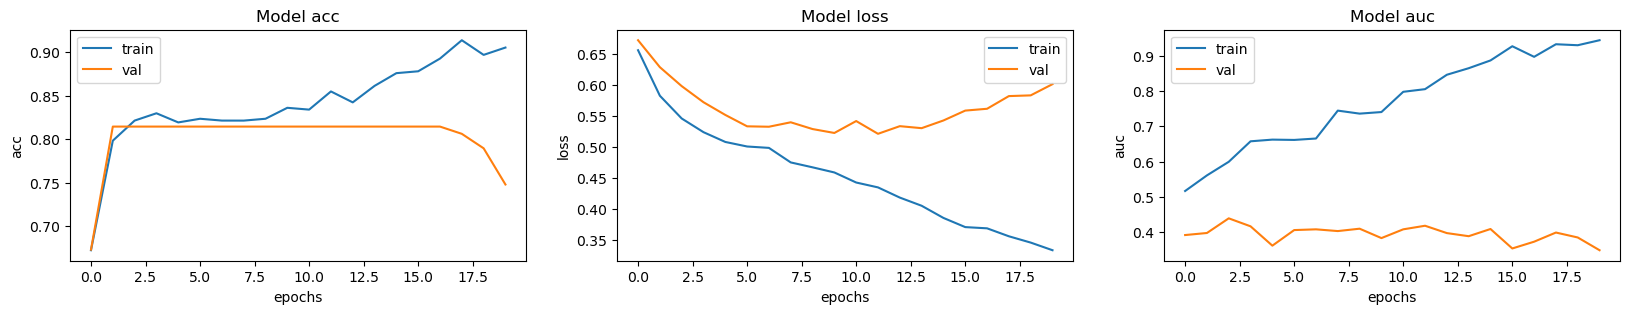

In [84]:
avg = {}
for metric in ["acc", "loss", 'auc']:
    avg[metric] = [sum(value) / 5 for value in zip(fold_history[0][metric], fold_history[1][metric], fold_history[2][metric], fold_history[3][metric], fold_history[4][metric])]
    avg['val_' + metric] = [sum(value) / 5 for value in zip(fold_history[0]['val_' + metric], fold_history[1]['val_' + metric], fold_history[2]['val_' + metric], fold_history[3]['val_' + metric], fold_history[4]['val_' + metric])]

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss", 'auc']):
    ax[i].plot(avg[metric])
    ax[i].plot(avg["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [85]:
max_auc_idx = np.argmax(avg['val_auc'])

print('acc:', avg['acc'][max_auc_idx])
print('loss:', avg['loss'][max_auc_idx])
print('auc:', avg['auc'][max_auc_idx])
print('val_acc:', avg['val_acc'][max_auc_idx])
print('val_loss:', avg['val_loss'][max_auc_idx])
print('val_auc:', avg['val_auc'][max_auc_idx])

acc: 0.8214035153388977
loss: 0.545636510848999
auc: 0.5994921922683716
val_acc: 0.8144927501678467
val_loss: 0.5976354360580445
val_auc: 0.4393655717372894


In [86]:
val_con_result = val_con[0]
for i in range(1, 5):
    val_con_result[0][0] += val_con[i][0][0]
    val_con_result[0][1] += val_con[i][0][1]
    val_con_result[1][0] += val_con[i][1][0]
    val_con_result[1][1] += val_con[i][1][1]

print('Confusion Matric(val): \n', val_con_result)
print('-' * 20)
t1a_val_result = t1a_val_con[0]
for i in range(1, 5):
    t1a_val_result[0][0] += t1a_val_con[i][0][0]
    t1a_val_result[0][1] += t1a_val_con[i][0][1]
    t1a_val_result[1][0] += t1a_val_con[i][1][0]
    t1a_val_result[1][1] += t1a_val_con[i][1][1]

print('Confusion Matric(t1a val): \n', t1a_val_result)


Confusion Matric(val): 
 [[89 22]
 [ 8  0]]
--------------------
Confusion Matric(t1a val): 
 [[84  8]
 [17  0]]


In [87]:
t1a_val_con

[array([[84,  8],
        [17,  0]], dtype=int64),
 array([[17,  0],
        [ 5,  0]], dtype=int64),
 array([[14,  8],
        [ 1,  0]], dtype=int64),
 array([[17,  0],
        [ 3,  0]], dtype=int64),
 array([[16,  0],
        [ 6,  0]], dtype=int64)]